Author: Angela Lekivetz

# Block 1: Feature Review & Enhancement

This stage focused on refining the time-series features to ensure they effectively capture temporal patterns in transit delay behavior. Because delay data evolves over time, features were designed to preserve chronological order and model short- and long-term dependencies.




In [1]:
# Import libraries
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings

from statsmodels.tsa.stattools import acf, pacf
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
from scipy.stats import boxcox

# Load dataset
df = pd.read_csv('cleaned_routes.csv').drop(columns=['Unnamed: 0'])

# Rename important columns for easier access
df = df.rename(columns={
    "calculation time": "timestamp",
    "actual delay (mins)": "actual_delay",
    "mean travel time (mins)": "mean_travel_time",
    "speed(km/h)": "speed_kmh",
    'current delay (mins)': 'current_delay'
})

# Drop unecessary columns
df = df.drop(columns=['speed(mph)'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort dataframe by route and timestamp
df = df.sort_values(['route', 'timestamp']).reset_index(drop=True)

df.head()

,timestamp,speed_kmh,mean_travel_time,actual_delay,current_delay,trend,route
0,2024-11-30 22:00:00,41.5,5.40,0.0,0.63,FLAT,Route 1
1,2024-11-30 22:01:00,41.4,5.42,0.0,0.65,FLAT,Route 1
2,2024-11-30 22:02:00,41.4,5.42,0.0,0.65,FLAT,Route 1
3,2024-11-30 22:03:00,41.2,5.43,0.0,0.67,FLAT,Route 1
4,2024-11-30 22:04:00,41.1,5.45,0.0,0.67,FLAT,Route 1


In [2]:
# Reference for later to sort route numbers
sorted_routes = sorted(df['route'].unique(), key=lambda x: int(x.split()[-1]) if x.split()[-1].isdigit() else x)

def sort_by_route(df):
    return df.sort_values(by='Route', key=lambda col: col.str.extract(r'(\d+)')[0].astype(int))

## Extreme Delay Outlier Analysis

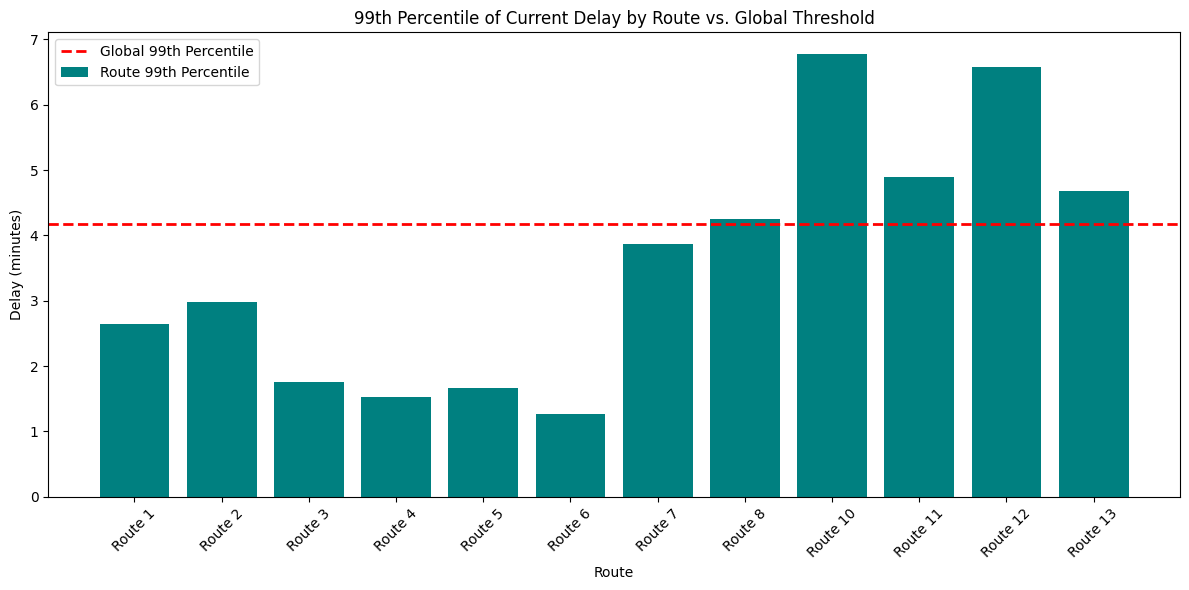

In [3]:
percentiles = []

# Compute per-route 99th percentile
for route in sorted_routes:
    route_data = df[df['route'] == route]
    current_delay_99th = route_data['current_delay'].quantile(0.99)
    percentiles.append(current_delay_99th)

# Compute global 99th percentile across all data
global_99th = df['current_delay'].quantile(0.99)

# Plot
plt.figure(figsize=(12,6))
bars = plt.bar(sorted_routes, percentiles, color='teal', label='Route 99th Percentile')
plt.axhline(global_99th, color='red', linestyle='--', linewidth=2, label='Global 99th Percentile')

plt.title('99th Percentile of Current Delay by Route vs. Global Threshold')
plt.xlabel('Route')
plt.ylabel('Delay (minutes)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


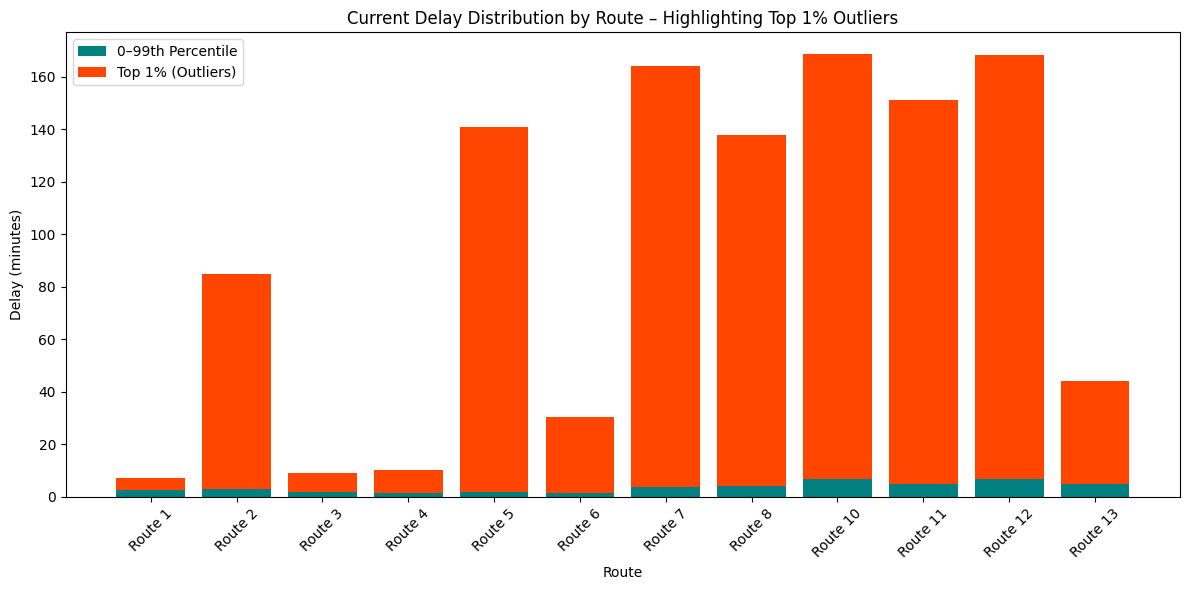

In [4]:
# Compute route-level 99th percentile and total max
data = []
for route in sorted_routes:
    route_data = df[df['route'] == route]
    p99 = route_data['current_delay'].quantile(0.99)
    max_val = route_data['current_delay'].max()
    data.append({'route': route, 'p99': p99, 'max': max_val})

percentile_df = pd.DataFrame(data)

# Compute the part of delay above the 99th percentile
percentile_df['extreme'] = percentile_df['max'] - percentile_df['p99']
percentile_df['regular'] = percentile_df['p99']

# Plot stacked bar chart
plt.figure(figsize=(12,6))
plt.bar(percentile_df['route'], percentile_df['regular'], color='teal', label='0–99th Percentile')
plt.bar(percentile_df['route'], percentile_df['extreme'], bottom=percentile_df['regular'], 
        color='orangered', label='Top 1% (Outliers)')

plt.title('Current Delay Distribution by Route – Highlighting Top 1% Outliers')
plt.xlabel('Route')
plt.ylabel('Delay (minutes)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### 99th Percentile Delay Comparison by Route

This chart visualizes the 99th percentile of `current_delay` (teal) compared with the total range of delay values (red). 
For most routes, the upper 1% of observations extend far beyond typical operating conditions, contributing disproportionately to the overall range. 

These extreme spikes likely represent non-operational anomalies due to sensor or data logging errors, and justify the decision to cap or remove values beyond the 99th percentile threshold.


In [5]:
# Look at the top 1% of delays
threshold = df['current_delay'].quantile(0.99)
extreme_rows = df[df['current_delay'] > threshold]

print(f"Number of extreme delays: {len(extreme_rows)}")
display(extreme_rows[['timestamp', 'route', 'current_delay', 'actual_delay', 'mean_travel_time']].sort_values('current_delay', ascending=False).head(20))


Number of extreme delays: 38655


,timestamp,route,current_delay,actual_delay,mean_travel_time
385327,2025-06-28 16:36:00,Route 10,168.42,112.50,119.75
1078111,2025-06-28 16:36:00,Route 12,168.35,113.30,117.72
385326,2025-06-28 16:35:00,Route 10,167.90,112.52,119.77
1078110,2025-06-28 16:35:00,Route 12,167.83,113.35,117.77
385325,2025-06-28 16:34:00,Route 10,167.25,112.62,119.87
1078109,2025-06-28 16:34:00,Route 12,167.18,113.45,117.87
385324,2025-06-28 16:33:00,Route 10,166.43,112.62,119.87
1078108,2025-06-28 16:33:00,Route 12,166.37,113.45,117.87
385328,2025-06-28 16:37:00,Route 10,165.85,102.50,109.75
1078112,2025-06-28 16:37:00,Route 12,165.78,103.28,107.70


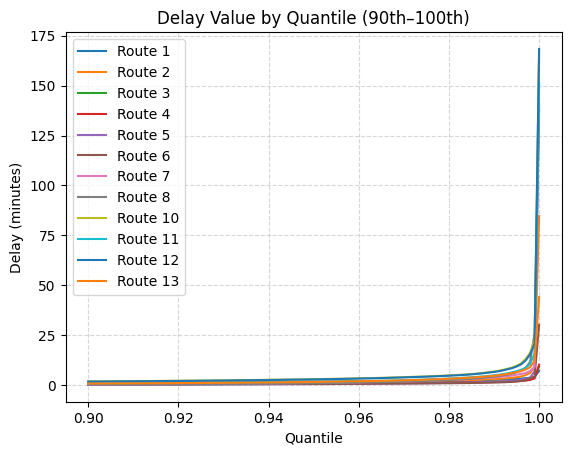

In [6]:
for route in sorted_routes:
    route_data = df[df['route'] == route]['current_delay']
    q = np.arange(0.90, 1.001, 0.001)
    plt.plot(q, route_data.quantile(q), label=route)

plt.title('Delay Value by Quantile (90th–100th)')
plt.xlabel('Quantile')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


### Quantile Analysis for Outlier Threshold Selection

The quantile plot above compares `current_delay` values between the 90th and 100th percentiles for all routes. 
Delays remain stable and near zero until approximately the 99.5th percentile, where an abrupt vertical increase occurs across multiple routes. 
This pattern indicates that values above this point represent systemic anomalies rather than genuine operational delays. 

Therefore, the 99.9th percentile was selected as the upper threshold for outlier removal. 
This decision effectively excludes the unrealistic spikes while preserving as much of the data as possible. 


In [7]:
# Remove top 0.1% extreme delays (per route)
cleaned_df = df.copy()

for route in sorted_routes:
    route_threshold = cleaned_df.loc[cleaned_df['route'] == route, 'current_delay'].quantile(0.999)
    cleaned_df = cleaned_df[
        ~((cleaned_df['route'] == route) & (cleaned_df['current_delay'] > route_threshold))
    ]

print(f"Removed {len(df) - len(cleaned_df)} outlier rows ({(1 - len(cleaned_df)/len(df))*100:.3f}% of data)")


Removed 3866 outlier rows (0.100% of data)


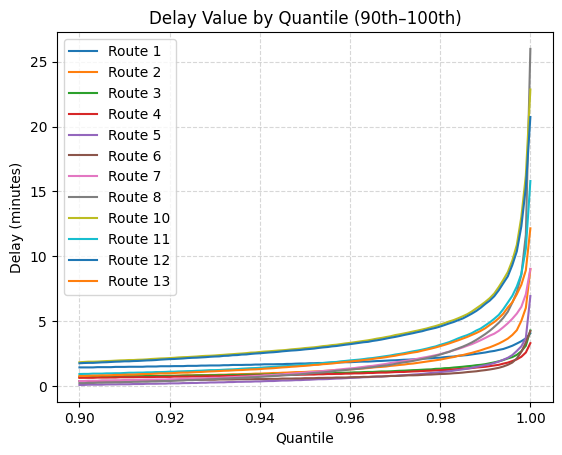

In [8]:
df = cleaned_df.copy()

for route in sorted_routes:
    route_data = df[df['route'] == route]['current_delay']
    q = np.arange(0.90, 1.001, 0.001)
    plt.plot(q, route_data.quantile(q), label=route)

plt.title('Delay Value by Quantile (90th–100th)')
plt.xlabel('Quantile')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [9]:
# Export csv for tableau
df.to_csv('cleaned_routes_no_outliers.csv', index=False)

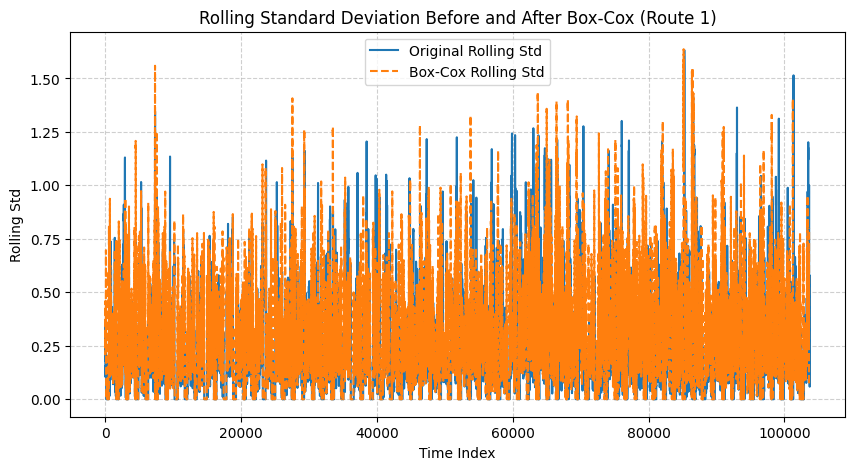

In [156]:
# Checking if Box-Cox is needed for variance stabilization

route_sample = df[df['route'] == 'Route 1']['current_delay'].dropna()

# Compute rolling standard deviations
rolling_std_original = route_sample.rolling(window=30).std()
transformed, _ = boxcox(route_sample[route_sample > 0] + 1e-6)  # Box-Cox requires positive values
rolling_std_boxcox = pd.Series(transformed).rolling(window=30).std()

# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(rolling_std_original, label='Original Rolling Std')
plt.plot(rolling_std_boxcox, label='Box-Cox Rolling Std', linestyle='--')
plt.title('Rolling Standard Deviation Before and After Box-Cox (Route 1)')
plt.xlabel('Time Index')
plt.ylabel('Rolling Std')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### Box-Cox Transformation Review

To test whether variance stabilization was needed, a Box-Cox transformation was applied to a representative route (Route 1). 

The rolling standard deviation of the transformed series showed no meaningful improvement over the original, confirming that the delay data already had stable variance across time.  

Because the delay variable is naturally bounded at zero and dominated by small values, applying Box-Cox would not enhance model performance and could distort the scale of lag and rolling features.  

Therefore, the transformation was **not applied**, and the raw delay values were retained for interpretability and consistency.


## Feature Engineering Setup

In this step, we add useful explanatory features before creating time-series lags.
These features help the model detect structure in delays:
- **Time-based features** (`hour`, `day_of_week`, `is_weekend`) capture rush hour patterns
- **Distance feature** derived from speed and travel time
- **Trend encoding** helps retain direction of change (UP/DOWN/FLAT)

This prepares the dataset for lag and rolling window generation.


In [157]:
# Time features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Distance feature: km = speed * time(hours)
df['distance_km'] = df['speed_kmh'] * df['mean_travel_time'] / 60

# One hot encode trend column, drop first to avoid multicollinearity
df = pd.get_dummies(df, columns=['trend'], drop_first=True)
df.columns = df.columns.str.lower().str.strip()

df.head()

,timestamp,speed_kmh,mean_travel_time,actual_delay,current_delay,route,hour,day_of_week,is_weekend,distance_km,trend_ flat,trend_ up
0,2024-11-30 22:00:00,41.5,5.40,0.0,0.63,Route 1,22,5,1,3.73500,True,False
1,2024-11-30 22:01:00,41.4,5.42,0.0,0.65,Route 1,22,5,1,3.73980,True,False
2,2024-11-30 22:02:00,41.4,5.42,0.0,0.65,Route 1,22,5,1,3.73980,True,False
3,2024-11-30 22:03:00,41.2,5.43,0.0,0.67,Route 1,22,5,1,3.72860,True,False
4,2024-11-30 22:04:00,41.1,5.45,0.0,0.67,Route 1,22,5,1,3.73325,True,False


## Automatic Lag Feature Selection (PACF/ACF)

We select **route-specific** time-series features without plots:
- **PACF** identifies significant **direct** lags (up to 12) for `actual_delay` and `mean_travel_time`.
- **ACF** suggests rolling windows (we probe 3h/6h/12h; include those with correlation ≥ 0.10; default to 6h if none).
- Features are created **per route** to respect each route’s dynamics.
- We store the chosen lags/roll windows in `lag_config_by_route` for reproducibility and later reporting.



In [158]:
def suggest_lags(series, max_lags=12, pacf_threshold=0.1):
    s = series.dropna()

    try:
        vals = pacf(s, nlags=max_lags, method='burg')
        vals = np.nan_to_num(vals)  # replace NaN/Inf with 0
    except Exception:
        return [1, 2]
    lags = [lag for lag, val in enumerate(vals) if lag != 0 and abs(val) >= pacf_threshold]
    return sorted(set(lags))[:5] if lags else [1, 2]

def suggest_rolling_windows(series, acf_threshold=0.1):
    s = series.dropna()
    if s.nunique() < 2 or len(s) < 5:
        return [6]
    try:
        vals = acf(s, nlags=24, missing='drop')
        vals = np.nan_to_num(vals)
    except Exception:
        return [6]
    wins = []
    if len(vals) > 3  and abs(vals[3])  >= acf_threshold: wins.append(3)
    if len(vals) > 6  and abs(vals[6])  >= acf_threshold: wins.append(6)
    if len(vals) > 12 and abs(vals[12]) >= acf_threshold: wins.append(12)
    if len(vals) > 24 and abs(vals[24]) >= acf_threshold: wins.append(24)
    return wins or [6]

# Run for all routes - delay and travel time
lag_summary = []

for route in sorted_routes:
    subset = df[df['route'] == route].sort_values('timestamp')

    delay_lags = suggest_lags(subset['current_delay'])
    travel_lags = suggest_lags(subset['mean_travel_time'])
    delay_roll = suggest_rolling_windows(subset['current_delay'])
    travel_roll = suggest_rolling_windows(subset['mean_travel_time'])

    lag_summary.append({
        'Route': route,
        'Delay Lags': delay_lags,
        'Travel Time Lags': travel_lags,
        'Delay Rolling Windows': delay_roll,
        'Travel Time Rolling Windows': travel_roll
    })

lag_df = sort_by_route(pd.DataFrame(lag_summary))
display(lag_df)

,Route,Delay Lags,Travel Time Lags,Delay Rolling Windows,Travel Time Rolling Windows
0,Route 1,"[1, 2, 3]","[1, 2]","[3, 6, 12, 24]","[3, 6, 12, 24]"
1,Route 2,"[1, 2]","[1, 2]","[3, 6, 12, 24]","[3, 6, 12, 24]"
2,Route 3,"[1, 2, 3]","[1, 2]","[3, 6, 12, 24]","[3, 6, 12, 24]"
3,Route 4,"[1, 2, 3]","[1, 2]","[3, 6, 12, 24]","[3, 6, 12, 24]"
4,Route 5,"[1, 2]","[1, 2]","[3, 6, 12, 24]","[3, 6, 12, 24]"
5,Route 6,"[1, 2, 5, 11, 12]","[1, 2, 3, 5, 7]","[3, 6, 12, 24]","[3, 6, 12, 24]"
6,Route 7,"[1, 2, 3]","[1, 2]","[3, 6, 12, 24]","[3, 6, 12, 24]"
7,Route 8,"[1, 2, 3]","[1, 2]","[3, 6, 12, 24]","[3, 6, 12, 24]"
8,Route 10,"[1, 2]","[1, 2]","[3, 6, 12, 24]","[3, 6, 12, 24]"
9,Route 11,"[1, 2, 3]","[1, 2]","[3, 6, 12, 24]","[3, 6, 12, 24]"


## Feature Engineering and Data Splitting Strategy

Time series forecasting requires preserving temporal order and leveraging information from past observations. Since bus delays often depend on recent travel conditions, the feature engineering process focused on capturing temporal dependencies through **lag features** and **rolling window statistics**.

### Temporal Feature Construction

**Lag features** were created by shifting the target variable (`current_delay`) and `mean_travel_time` backward in time (e.g., `delay_lag_1`, `delay_lag_2`, `travel_lag_1`, `travel_lag_2`). These features capture short-term persistence—if a route experiences a delay now, it is more likely to remain delayed shortly after.

**Rolling window features** summarize recent delay patterns to capture congestion trends. Two window sizes were used:
- **6-step window:** captures localized fluctuations (short-term delay bursts)
- **12-step window:** captures smoother, sustained congestion trends

For both `current_delay` and `mean_travel_time`, rolling **means** and **maximums** were computed to reflect recent averages and extreme peaks. Together, these temporal features enhance the model’s ability to learn from both stable and irregular traffic behavior.

All features were generated **after splitting by route and time**, ensuring that only past information was used for feature computation—preventing data leakage. Rows missing sufficient historical context (due to lag or rolling operations) were removed to maintain clean, complete training inputs.

### Cross-Validation and Holdout Design

To evaluate model performance accurately, the dataset for each route was split chronologically:
- The **first 80%** of data was used for model development and cross-validation.
- The **most recent 20%** was reserved as a **holdout set** for final testing.

This **time-based split** reflects real deployment conditions where predictions must be made using past data only.

Within the training portion, a **time-aware cross-validation** approach was implemented using `TimeSeriesSplit`. Unlike random k-fold methods, which risk leaking future data, `TimeSeriesSplit` builds sequential folds - each training on earlier periods and validating on subsequent ones. This simulates real-world forecasting and tests whether the model can generalize across time, not just across samples.

### Rationale

This combined feature engineering and splitting approach ensures:
- Temporal patterns are preserved and learned effectively.
- Evaluation is fair and leakage-free.
- Both short-term (lag) and trend-based (rolling) dependencies are modeled.
- Model performance reflects real-world prediction reliability.

| Component | Purpose | Key Techniques |
|------------|----------|----------------|
| Lag Features | Capture short-term delay persistence | `delay_lag_1`, `delay_lag_2`, `travel_lag_1`, `travel_lag_2` |
| Rolling Features | Capture trends and peaks | Rolling mean and max (6, 12 steps) |
| Data Splitting | Preserve temporal order | 80/20 time-based split |
| Cross-Validation | Evaluate forward-in-time performance | `TimeSeriesSplit` |


In [159]:
TARGET = 'current_delay'
TIME_COL = 'timestamp'

X_train_cv     = {}
y_train_cv     = {}
X_test_holdout = {}
y_test_holdout = {}
tscv_splits    = {}

sorted_route_vals = sorted(df['route'].unique().tolist())

def is_engineered(name): 
    prefixes = ('delay_lag_', 'travel_lag_', 'delay_roll_', 'travel_roll_')
    return name.startswith(prefixes)

# Base features = everything except target/time/route and except any engineered columns
base_feature_columns = [
    c for c in df.columns
    if c not in {'current_delay', 'timestamp', 'route'} and not is_engineered(c)
]

# Chosen engineered features
lag_list     = [1, 2]
roll_windows = [6, 12]

for route in sorted_route_vals:
    route_data = df[df['route'] == route].sort_values(TIME_COL).copy()
    n = len(route_data)

    # Require minimal length for stable windows and evaluation
    if n < max(roll_windows) + 10:
        continue

    # 80/20 chronological split
    split_idx  = int(n * 0.8)
    cv_data    = route_data.iloc[:split_idx].copy()
    hold_data  = route_data.iloc[split_idx:].copy()

    # ---- Create lags AFTER split (leak-safe) ----
    for i in lag_list:
        cv_data[f'delay_lag_{i}']   = cv_data[TARGET].shift(i)
        cv_data[f'travel_lag_{i}']  = cv_data['mean_travel_time'].shift(i)
        hold_data[f'delay_lag_{i}'] = hold_data[TARGET].shift(i)
        hold_data[f'travel_lag_{i}']= hold_data['mean_travel_time'].shift(i)

    # ---- Create rolling windows AFTER split (leak-safe) ----
    for w in roll_windows:
        # Delay windows
        cv_data[f'delay_roll_mean_{w}']  = cv_data[TARGET].rolling(w, min_periods=w).mean()
        cv_data[f'delay_roll_max_{w}']   = cv_data[TARGET].rolling(w, min_periods=w).max()
        hold_data[f'delay_roll_mean_{w}']= hold_data[TARGET].rolling(w, min_periods=w).mean()
        hold_data[f'delay_roll_max_{w}'] = hold_data[TARGET].rolling(w, min_periods=w).max()
        # Travel windows
        cv_data[f'travel_roll_mean_{w}'] = cv_data['mean_travel_time'].rolling(w, min_periods=w).mean()
        cv_data[f'travel_roll_max_{w}']  = cv_data['mean_travel_time'].rolling(w, min_periods=w).max()
        hold_data[f'travel_roll_mean_{w}']= hold_data['mean_travel_time'].rolling(w, min_periods=w).mean()
        hold_data[f'travel_roll_max_{w}'] = hold_data['mean_travel_time'].rolling(w, min_periods=w).max()

    # Drop rows with any NaNs due to shifts/windows (Choice A)
    engineered_cols = [f'delay_lag_{i}' for i in lag_list] + \
                      [f'travel_lag_{i}' for i in lag_list]
    for w in roll_windows:
        engineered_cols += [
            f'delay_roll_mean_{w}', f'delay_roll_max_{w}',
            f'travel_roll_mean_{w}', f'travel_roll_max_{w}'
        ]

    cv_data   = cv_data.dropna(subset=engineered_cols)
    hold_data = hold_data.dropna(subset=engineered_cols)

    # Ensure enough data remains for training/evaluation
    if len(cv_data) < 20 or len(hold_data) < 5:
        continue

    # Final feature list
    feature_cols = base_feature_columns + engineered_cols

    # Save holdout
    X_test_holdout[route] = hold_data[feature_cols].copy()
    y_test_holdout[route] = hold_data[TARGET].copy()

    # Save CV data + folds (time-aware CV)
    X_cv, y_cv = cv_data[feature_cols].copy(), cv_data[TARGET].copy()
    tscv = TimeSeriesSplit(n_splits=3)
    X_train_cv[route], y_train_cv[route], tscv_splits[route] = X_cv, y_cv, list(tscv.split(X_cv))

print(f"Prepared routes: {len(X_train_cv)} (CV) / {len(X_test_holdout)} (Holdout)")


Prepared routes: 12 (CV) / 12 (Holdout)


## Justification for Not Using ARIMA or SARIMA Models

Traditional ARIMA and SARIMA models were not used in this project because the problem and dataset do not meet their core assumptions or structural requirements.

1. **Multivariate, Feature-Rich Data**  
   The forecasting task depends on several predictors (e.g., mean travel time, lagged delays, and rolling statistics).  
   ARIMA and SARIMA are primarily **univariate** models that use only a single series’ past values to make predictions.  
   Extending them to handle multiple explanatory variables (via SARIMAX) would complicate tuning and still provide limited flexibility compared to tree-based regressors.

2. **Non-stationary and Event-Driven Behavior**  
   Transit delay data show **irregular spikes** caused by weather, congestion, or operational disruptions, rather than smooth seasonal or trend patterns.  
   ARIMA/SARIMA require stationarity or regular seasonality, which is not present here.  
   Differencing to force stationarity would remove useful short-term variability that the machine learning models can directly learn.

3. **Multiple Independent Routes**  
   The dataset contains many separate route-level time series.  
   Training, diagnosing, and tuning an ARIMA/SARIMA model for each route individually would be computationally inefficient and inconsistent, whereas ensemble regressors can apply a unified feature structure across all routes.

4. **Short-Term Forecast Horizon**  
   The goal is near-term prediction of bus delays rather than long-horizon forecasting with seasonal cycles.  
   Tree-based models such as Random Forest and XGBoost handle short-range dependencies efficiently through engineered lag and rolling features, without relying on long autocorrelation structures.

5. **Model Flexibility and Interpretability**  
   Lag and rolling features already replicate the autoregressive component that ARIMA models provide, but in a form that can be combined with other contextual predictors.  
   Ensemble methods handle nonlinear relationships, mixed scales, and outliers more robustly while remaining easier to compare across routes.



# Block 2: Model Selection & Training

## Baseline Model Justification

Before developing machine learning models, a baseline model was established to provide a reference level of predictive performance. The purpose of the baseline is not to produce highly accurate predictions, but to define a minimum standard that any forecasting model must exceed in order to justify its complexity.

A naïve persistence baseline was used, defined as:

    current_delay(t) = current_delay(t−1)

This approach assumes that the most recent delay is a reasonable estimate of the next delay value. This assumption is appropriate in transportation networks because delays often exhibit short-term temporal persistence; once a route begins to fall behind schedule, operational recovery may take several intervals. Therefore, the lag-1 delay feature (delay_lag_1) provides a meaningful baseline for comparison and reflects realistic operational dynamics.

The lag-1 baseline was evaluated on the holdout set to ensure that it did not unintentionally benefit from data leakage. Since the baseline uses historical delay values only, it maintains causality and does not rely on future observations. If more complex models do not improve upon this baseline, it would indicate that delay behavior is mostly autoregressive with limited additional signal available from engineered features.

Evaluating the baseline model before introducing machine learning methods ensures that model development is justified and transparent. Forecasting performance must meaningfully exceed this simple benchmark to demonstrate that the use of more advanced models provides operational value.


In [160]:
baseline_results = []

for route, X_hold in X_test_holdout.items():
    if 'delay_lag_1' not in X_hold.columns:
        continue

    y_true = y_test_holdout[route]
    y_pred = X_hold['delay_lag_1']  # naïve baseline

    # Hard align by index to avoid accidental misalignment
    y_true, y_pred = y_true.align(y_pred, join='inner')

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    baseline_results.append({'Route': route, 'Baseline MAE': mae, 'Baseline RMSE': rmse})

baseline_df = sort_by_route(pd.DataFrame(baseline_results)).reset_index(drop=True)

print("--- Holdout Baseline (Predict delay_lag_1) ---\n")
display(baseline_df)


--- Holdout Baseline (Predict delay_lag_1) ---



,Route,Baseline MAE,Baseline RMSE
0,Route 1,0.050866,0.095236
1,Route 2,0.036768,0.105888
2,Route 3,0.028173,0.062635
3,Route 4,0.033210,0.065626
4,Route 5,0.016865,0.075252
5,Route 6,0.021275,0.064641
6,Route 7,0.021038,0.069079
7,Route 8,0.031498,0.143073
8,Route 10,0.058385,0.187260
9,Route 11,0.040908,0.146024


## Model Selection and Training

Model selection aimed to identify algorithms capable of capturing nonlinear and temporal relationships in the engineered features. Since the target variable (`current_delay`) is continuous, the problem was framed as a regression task.

Three model families were considered: linear regression, tree-based ensembles, and gradient boosting methods. Linear models served as a baseline but were insufficient for modeling complex, nonlinear relationships arising from traffic dynamics and delay propagation. Tree-based models such as **Random Forest** and **XGBoost** were therefore prioritized. These models handle nonlinearity, mixed feature scales, and outliers effectively. XGBoost was especially suitable due to its regularization, efficiency, and strong performance on structured tabular data.

All models were evaluated using **time-aware cross-validation** (`TimeSeriesSplit`) to preserve chronological order. Performance was measured using **Mean Absolute Error (MAE)** and **Root Mean Square Error (RMSE)**. MAE was prioritized as it expresses the average prediction error in minutes and is less affected by outliers than RMSE. The best model for each route was chosen based on the lowest Holdout MAE.

---

## Route-Level Model Training and Evaluation

Models were trained **independently per route** to capture unique delay dynamics influenced by route-specific traffic and operational conditions. A global model would generalize poorly due to differing delay behaviors.

For each route:

- Two regressors were tested:
  - `RandomForestRegressor`
  - `XGBRegressor`
- **TimeSeriesSplit** was used for leak-free validation.
- Evaluation metrics:
  - Cross-validation MAE and RMSE (for consistency)
  - Holdout MAE and RMSE (for generalization)
- The best model per route was selected using Holdout MAE.
- A **naïve baseline** (`delay_lag_1`) predicted that the next delay equals the previous one.
- Model predictions, baseline results, and residuals were stored for diagnostics.

The resulting `comparison_df` table summarizes route-level performance relative to the baseline. The following code block trains and evaluates the models for each route according to this process.


In [175]:
model_routes = [route for route in X_train_cv.keys()]

model_results = []          # cv + holdout metrics for each route
final_predictions = {}      # best model predictions per route
baseline_predictions = {}   # baseline predictions per route
final_residuals = {}        # residuals per route using best model
model_objects = {}          # model objects per route

# Loop through each route and train models independently
for route in tqdm(model_routes, desc='Training models by route'):
    X_cv = X_train_cv[route]          # features for time series cross-validation
    y_cv = y_train_cv[route]          # targets for cross-validation
    folds = tscv_splits[route]        # precomputed TimeSeriesSplit folds
    X_test = X_test_holdout[route]    # holdout features for final evaluation
    y_test = y_test_holdout[route]    # holdout target features

    # Track best model based on holdout MAE
    best_model_info = None

    for model_name, model in [
        ('RandomForest', RandomForestRegressor(n_estimators=200, max_depth=8,random_state=42)),
        ('XGBoost', XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, random_state=42))
    ]:
        fold_scores = []   # CV scores for current model

        # TimeSeriesSplit cross-validation
        for train_idx, val_idx in folds:
            X_train, X_val = X_cv.iloc[train_idx], X_cv.iloc[val_idx]
            y_train, y_val = y_cv.iloc[train_idx], y_cv.iloc[val_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            mae = mean_absolute_error(y_val, y_pred)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            fold_scores.append((mae, rmse))

        avg_mae, avg_rmse = np.mean(fold_scores, axis=0)

        # Evaluate on holdout set
        holdout_preds = model.predict(X_test)
        holdout_mae = mean_absolute_error(y_test, holdout_preds)
        holdout_rmse = np.sqrt(mean_squared_error(y_test, holdout_preds))

        # Save results for comparison table
        result = {
            'Route': route,
            'Model': model_name,
            'CV MAE': avg_mae,
            'CV RMSE': avg_rmse,
            'Holdout MAE': holdout_mae,
            'Holdout RMSE': holdout_rmse, 
            'Predictions': holdout_preds
        }
        model_results.append(result)

        # Track best model based on Holdout MAE
        if best_model_info is None or holdout_mae < best_model_info['Holdout MAE']:
            best_model_info = result
            best_trained_model = model

    # Save best model, predictions and residuals
    model_objects[route] = best_trained_model
    final_predictions[route] = best_model_info['Predictions']
    final_residuals[route] = y_test.values - best_model_info['Predictions']

    # Save baseline (lag-1) predictions for comparison
    baseline_predictions[route] = X_test['delay_lag_1'].values

# Convert to table
comparison_df = (
    pd.DataFrame(model_results)
    .sort_values(
        by=['Route', 'Holdout MAE'],
        key=lambda col: col.str.extract(r'(\d+)')[0].astype(int) if col.name == 'Route' else col
    )
    .reset_index(drop=True)
)

comparison_df = comparison_df.drop(columns=['Predictions'])
display(comparison_df)

Training models by route: 100%|██████████| 12/12 [45:54<00:00, 229.50s/it]


,Route,Model,CV MAE,CV RMSE,Holdout MAE,Holdout RMSE
0,Route 1,XGBoost,0.020709,0.039820,0.020177,0.036269
1,Route 1,RandomForest,0.025822,0.052430,0.025752,0.052682
2,Route 2,RandomForest,0.012624,0.036593,0.024987,0.088612
3,Route 2,XGBoost,0.009548,0.030797,0.033635,0.124663
4,Route 3,XGBoost,0.012850,0.027247,0.010863,0.020259
5,Route 3,RandomForest,0.016505,0.034159,0.014801,0.029425
6,Route 4,XGBoost,0.007471,0.015823,0.011370,0.023169
7,Route 4,RandomForest,0.010758,0.023162,0.014817,0.030161
8,Route 5,XGBoost,0.002657,0.033087,0.007363,0.052228
9,Route 5,RandomForest,0.003857,0.043056,0.010329,0.073706


## Model Comparison and Selection

To determine the most suitable forecasting model for each route, Random Forest Regressor and XGBoost Regressor were evaluated using the same engineered feature set and time-aware cross-validation strategy. Both models were trained independently for each route to account for route-specific delay behavior.

Model performance was assessed using mean absolute error (MAE) and root mean square error (RMSE). MAE was used as the primary evaluation metric because it is more interpretable in operational contexts; it measures the average delay prediction error in minutes. RMSE was used as a secondary metric due to its sensitivity to larger errors, allowing additional consideration of extreme delays.

For each route, the model with the lowest holdout MAE was selected as the best-performing model. RMSE was used for tie-breaking where necessary. Evaluating both models side by side ensures that model selection is based on empirical performance rather than assumptions, supporting a reliable and defensible model choice.


In [162]:
# Add baseline to model comparison table
comparison_full = comparison_df.merge(
    baseline_df[['Route', 'Baseline MAE', 'Baseline RMSE']],
    on='Route',
    how='left'
)
 
 # Find best model per route based on Holdout MAE
best_models = []
for route in model_routes:
    temp = comparison_full[comparison_full['Route'] == route]
    best_row = temp.loc[temp['Holdout MAE'].idxmin()]
    best_models.append(best_row)    

best_models_df = sort_by_route(pd.DataFrame(best_models)).reset_index(drop=True)

# Add percent improvement over baseline
best_models_df['Improvement Over Baseline (%)'] = (
    (best_models_df['Baseline MAE'] - best_models_df['Holdout MAE']) / best_models_df['Baseline MAE'] * 100
)

# Round for readability
best_models_df = best_models_df.round(4)
best_models_df['Improvement Over Baseline (%)'] = best_models_df['Improvement Over Baseline (%)'].round(2)

best_models_df



,Route,Model,CV MAE,CV RMSE,Holdout MAE,Holdout RMSE,Baseline MAE,Baseline RMSE,Improvement Over Baseline (%)
0,Route 1,XGBoost,0.0207,0.0398,0.0202,0.0363,0.0509,0.0952,60.33
1,Route 2,RandomForest,0.0126,0.0366,0.0250,0.0886,0.0368,0.1059,32.04
2,Route 3,XGBoost,0.0129,0.0272,0.0109,0.0203,0.0282,0.0626,61.44
3,Route 4,XGBoost,0.0075,0.0158,0.0114,0.0232,0.0332,0.0656,65.76
4,Route 5,XGBoost,0.0027,0.0331,0.0074,0.0522,0.0169,0.0753,56.34
5,Route 6,XGBoost,0.0308,0.0613,0.0165,0.0487,0.0213,0.0646,22.23
6,Route 7,RandomForest,0.0040,0.0248,0.0113,0.0399,0.0210,0.0691,46.35
7,Route 8,RandomForest,0.0059,0.0660,0.0180,0.0967,0.0315,0.1431,42.89
8,Route 10,RandomForest,0.0169,0.0888,0.0297,0.1037,0.0584,0.1873,49.08
9,Route 11,RandomForest,0.0087,0.0343,0.0212,0.0835,0.0409,0.1460,48.08


In [179]:
# Loop through each route and show top 5 feature importances
for route in sorted_routes:
    # Get model
    model = model_objects[route]
    # Create DataFrame of top 5 features
    feat_imp = pd.DataFrame({
        'Feature': X_train_cv[route].columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(5)

    # Display table
    print(f"\nTop 5 Feature Importances for {route}:")
    display(feat_imp)



Top 5 Feature Importances for Route 1:


,Feature,Importance
9,delay_lag_1,0.464141
10,delay_lag_2,0.357904
14,delay_roll_max_6,0.053645
2,actual_delay,0.053442
1,mean_travel_time,0.020438



Top 5 Feature Importances for Route 2:


,Feature,Importance
9,delay_lag_1,0.810509
1,mean_travel_time,0.068362
2,actual_delay,0.056903
0,speed_kmh,0.041789
14,delay_roll_max_6,0.008008



Top 5 Feature Importances for Route 3:


,Feature,Importance
9,delay_lag_1,0.460602
10,delay_lag_2,0.271415
11,travel_lag_1,0.130292
0,speed_kmh,0.031716
1,mean_travel_time,0.030661



Top 5 Feature Importances for Route 4:


,Feature,Importance
9,delay_lag_1,0.335349
10,delay_lag_2,0.192597
2,actual_delay,0.151452
1,mean_travel_time,0.129029
0,speed_kmh,0.095966



Top 5 Feature Importances for Route 5:


,Feature,Importance
1,mean_travel_time,0.471689
2,actual_delay,0.246341
0,speed_kmh,0.223591
9,delay_lag_1,0.032957
10,delay_lag_2,0.007436



Top 5 Feature Importances for Route 6:


,Feature,Importance
2,actual_delay,0.733480
0,speed_kmh,0.061208
10,delay_lag_2,0.044394
14,delay_roll_max_6,0.043983
13,delay_roll_mean_6,0.040620



Top 5 Feature Importances for Route 7:


,Feature,Importance
9,delay_lag_1,0.996491
2,actual_delay,0.000595
1,mean_travel_time,0.000565
15,travel_roll_mean_6,0.000468
14,delay_roll_max_6,0.000457



Top 5 Feature Importances for Route 8:


,Feature,Importance
9,delay_lag_1,0.923922
12,travel_lag_2,0.034350
15,travel_roll_mean_6,0.020622
13,delay_roll_mean_6,0.004668
14,delay_roll_max_6,0.003675



Top 5 Feature Importances for Route 10:


,Feature,Importance
9,delay_lag_1,0.988829
1,mean_travel_time,0.001624
11,travel_lag_1,0.001570
2,actual_delay,0.001420
14,delay_roll_max_6,0.001418



Top 5 Feature Importances for Route 11:


,Feature,Importance
9,delay_lag_1,0.982389
15,travel_roll_mean_6,0.010555
2,actual_delay,0.001240
1,mean_travel_time,0.001227
0,speed_kmh,0.001096



Top 5 Feature Importances for Route 12:


,Feature,Importance
9,delay_lag_1,0.989106
15,travel_roll_mean_6,0.001970
1,mean_travel_time,0.001773
2,actual_delay,0.001733
11,travel_lag_1,0.001675



Top 5 Feature Importances for Route 13:


,Feature,Importance
9,delay_lag_1,0.989960
1,mean_travel_time,0.001808
14,delay_roll_max_6,0.001802
2,actual_delay,0.001776
0,speed_kmh,0.001504


Some routes exhibited extremely high importance for the feature **`delay_lag_1`**, accounting for over **90%** of total model influence. Despite this dominance, the **holdout MAE and RMSE** values remained low, and each route achieved more than an improvement over the baseline model. 

This pattern indicates that these routes display **strong short-term autocorrelation**, meaning that delays in the most recent time step are highly predictive of delays in the next. In such cases, the previous delay value carries most of the relevant information needed for accurate one-step-ahead forecasting.

Because the models continue to **generalize well on unseen data**, this dependence on `delay_lag_1` is not a sign of overfitting but rather a reflection of the underlying temporal structure of these routes. **No additional feature adjustments were required.**


# Block 3: Model Evaluation and Diagnostics

The table above summarizes route-level model performance after training and evaluation. Each model’s accuracy was measured using **Mean Absolute Error (MAE)** and **Root Mean Square Error (RMSE)** across both cross-validation and holdout sets, with performance compared to a simple **naïve baseline** (`delay_lag_1`).

## Key Metrics Summary

| Metric | Description | Role in Evaluation |
|:--|:--|:--|
| **MAE** | Average absolute difference between predicted and actual delay | Primary metric, interpretable in minutes |
| **RMSE** | Root mean square of prediction errors | Secondary metric, highlights large errors |
| **Improvement (%)** | Relative gain over the baseline | Measures real-world benefit of model learning |

The combination of time-aware validation, holdout evaluation, and baseline comparison confirms that the selected models effectively capture temporal delay dynamics and provide meaningful forecasting improvements suitable for deployment in the Banff transit setting.


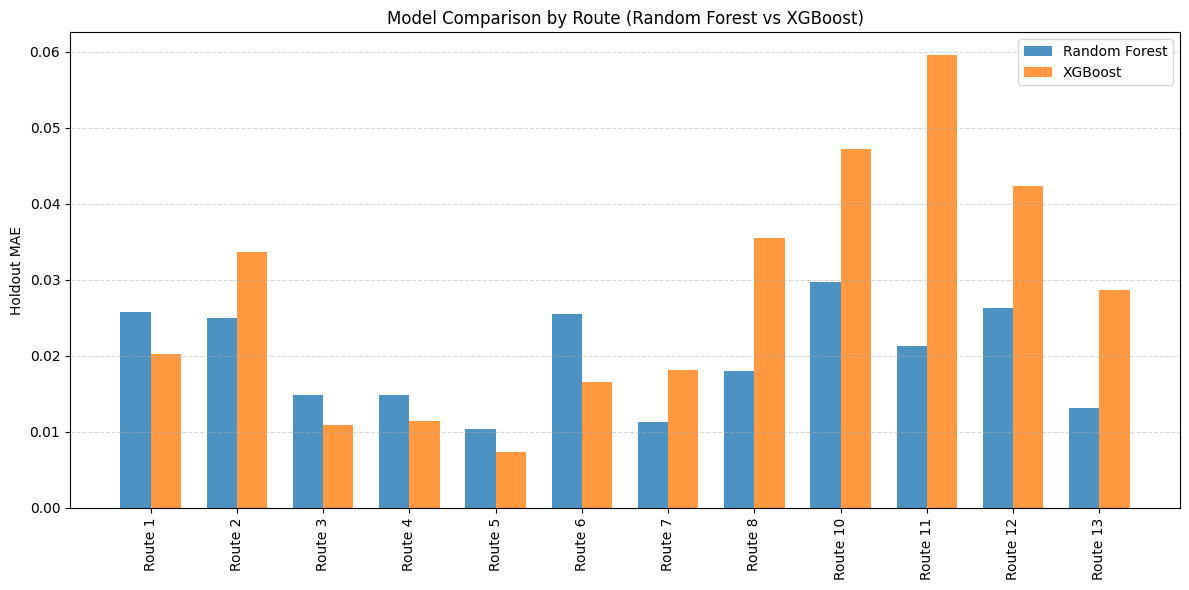

In [163]:
# Filter relevant data
rf_scores = comparison_df[comparison_df['Model'] == 'RandomForest'].set_index('Route')['Holdout MAE']
xgb_scores = comparison_df[comparison_df['Model'] == 'XGBoost'].set_index('Route')['Holdout MAE']

routes = rf_scores.index  
x = np.arange(len(routes))  
width = 0.35  

plt.figure(figsize=(12,6))
plt.bar(x - width/2, rf_scores, width, label='Random Forest', alpha=0.8)
plt.bar(x + width/2, xgb_scores, width, label='XGBoost', alpha=0.8)

plt.xticks(x, routes, rotation=90)
plt.ylabel('Holdout MAE')
plt.title('Model Comparison by Route (Random Forest vs XGBoost)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


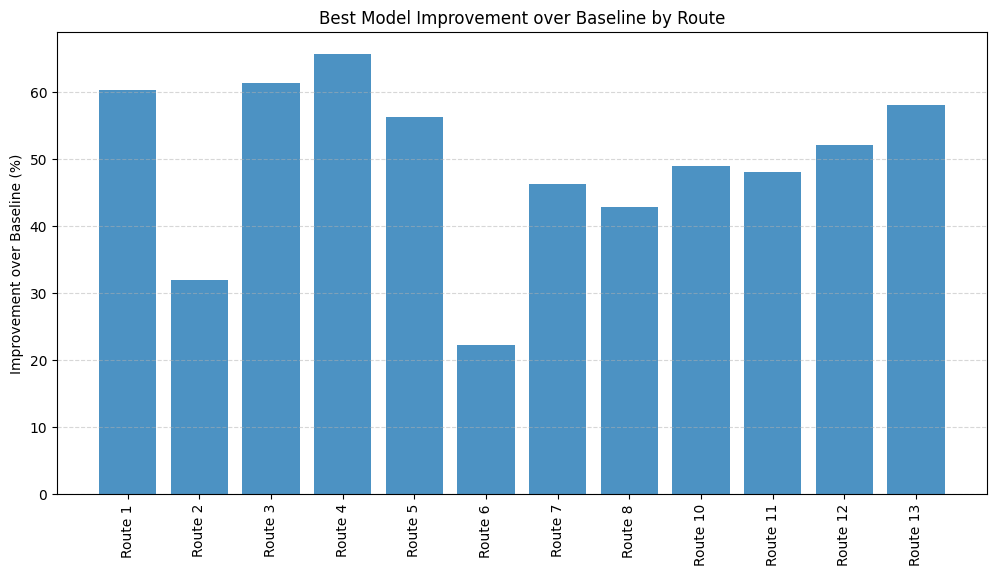

In [164]:
plt.figure(figsize=(12,6))
plt.bar(best_models_df['Route'], best_models_df['Improvement Over Baseline (%)'], alpha=0.8)
plt.xticks(rotation=90)
plt.ylabel('Improvement over Baseline (%)')
plt.title('Best Model Improvement over Baseline by Route')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


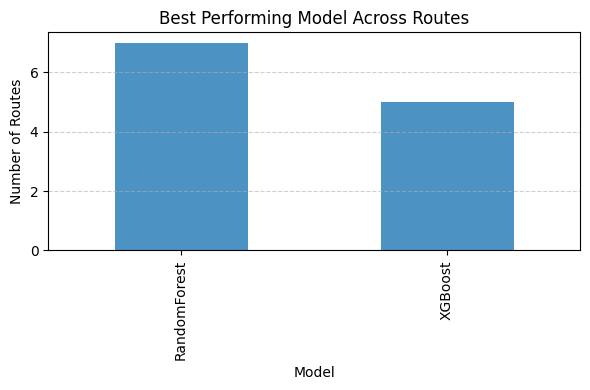

In [165]:
plt.figure(figsize=(6, 4))
best_models_df['Model'].value_counts().plot(kind='bar', alpha=0.8)
plt.ylabel('Number of Routes')
plt.title('Best Performing Model Across Routes')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Interpretation

Across all routes, both ensemble models substantially outperformed the naïve baseline predictor, confirming that the engineered lag and rolling features successfully captured temporal delay dependencies. Average improvements over the baseline ranged from **20 % to 65 %**, demonstrating strong generalization and meaningful predictive skill.

- **Random Forest** achieved the best results on the majority of routes (Routes 2, 7, 8, 10, 11, 12, and 13). 
- **XGBoost** performed best on more consistent routes with smoother temporal structure (Routes 1, 3, 4, 5, and 6). 
- Holdout MAE values remained low across all models, and improvements of up to **65%** over the baseline indicate that both algorithms generalized well to unseen data.

This complementary behavior highlights the importance of route-specific modeling rather than a single global model for all routes in the Banff network.


## Diagnostic Evaluation and Model Error Analysis

This section provides a detailed diagnostic evaluation for three representative routes to assess model fit and error behavior beyond scalar metrics. While summary metrics such as MAE and RMSE quantify overall accuracy, diagnostic plots allow a deeper look into model dynamics, revealing patterns of bias, drift, and variance.

### Route Selection Rationale

To capture a full spectrum of model behavior, three routes were selected based on their relative improvement over baseline:

- **Route 4 — High-Improvement Case (~66%)**  

- **Route 11 — Typical Case (~48%)**  
- **Route 6 — Low-Improvement Case (~22%)**  

### Diagnostic Plots and Observations

For each selected route, three diagnostic plots were generated:

1. **Predicted vs. Actual Delay Over Time**  
   Shows how the model’s temporal predictions align with actual observed delays.

2. **Residuals Over Time (Actual − Predicted)**  
   Reveals whether errors are random or structured, identifying trends, drift, or bias over time.

3. **Residual Distribution**  
   Illustrates the overall shape, spread, and symmetry of errors to detect skewness or systematic under/overprediction.





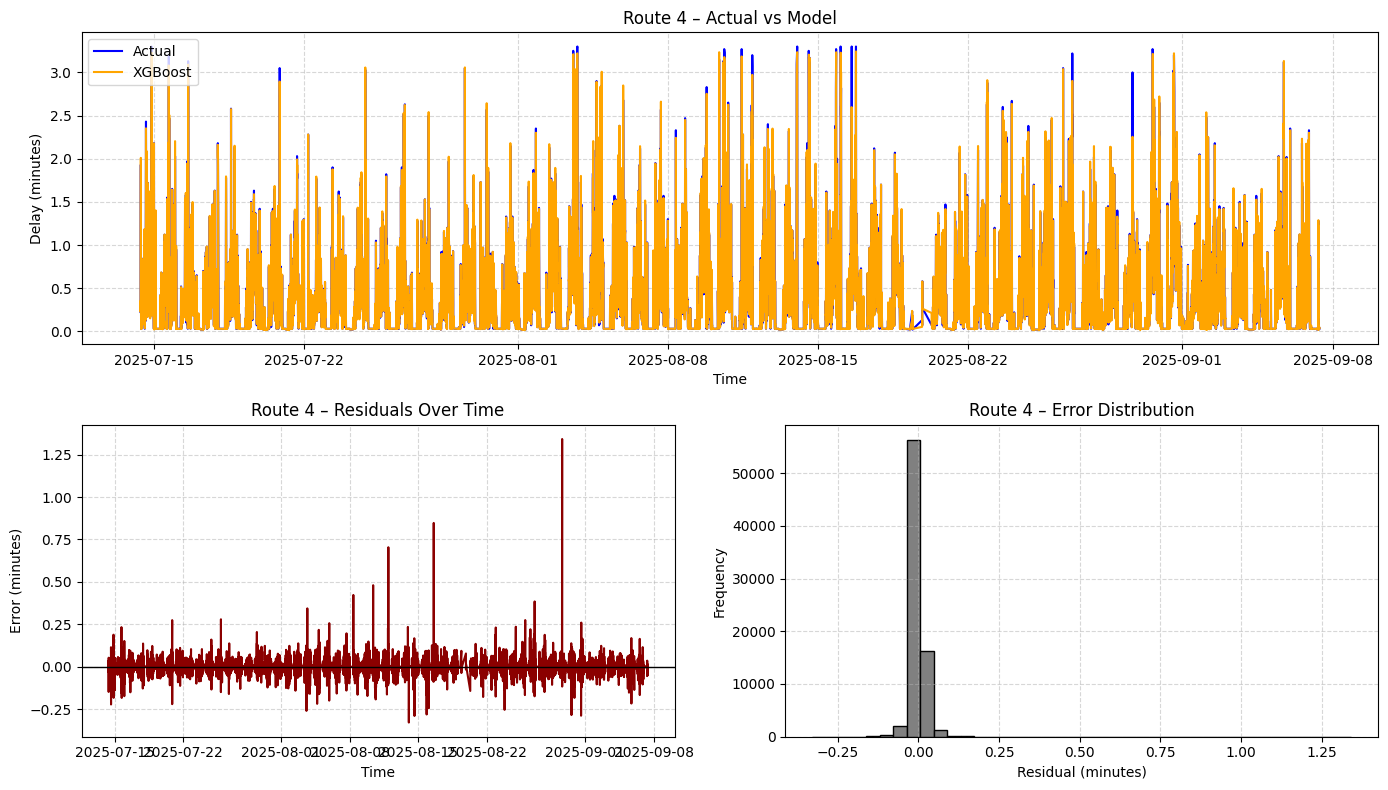


Route: Route 4
Best Model: XGBoost
Holdout MAE: 0.0114
Holdout RMSE: 0.0232
Baseline MAE: 0.0332
Improvement vs Baseline: 65.76%


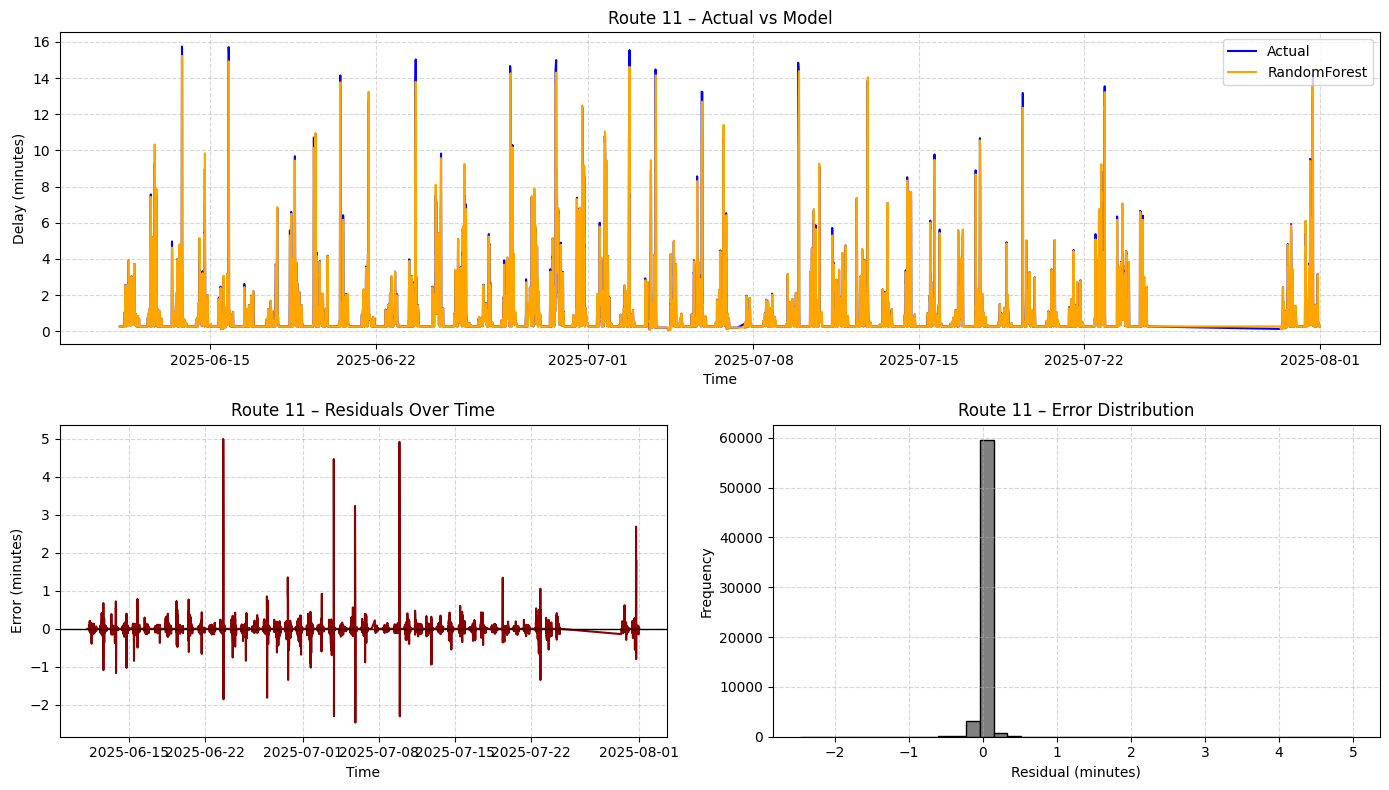


Route: Route 11
Best Model: RandomForest
Holdout MAE: 0.0212
Holdout RMSE: 0.0835
Baseline MAE: 0.0409
Improvement vs Baseline: 48.08%


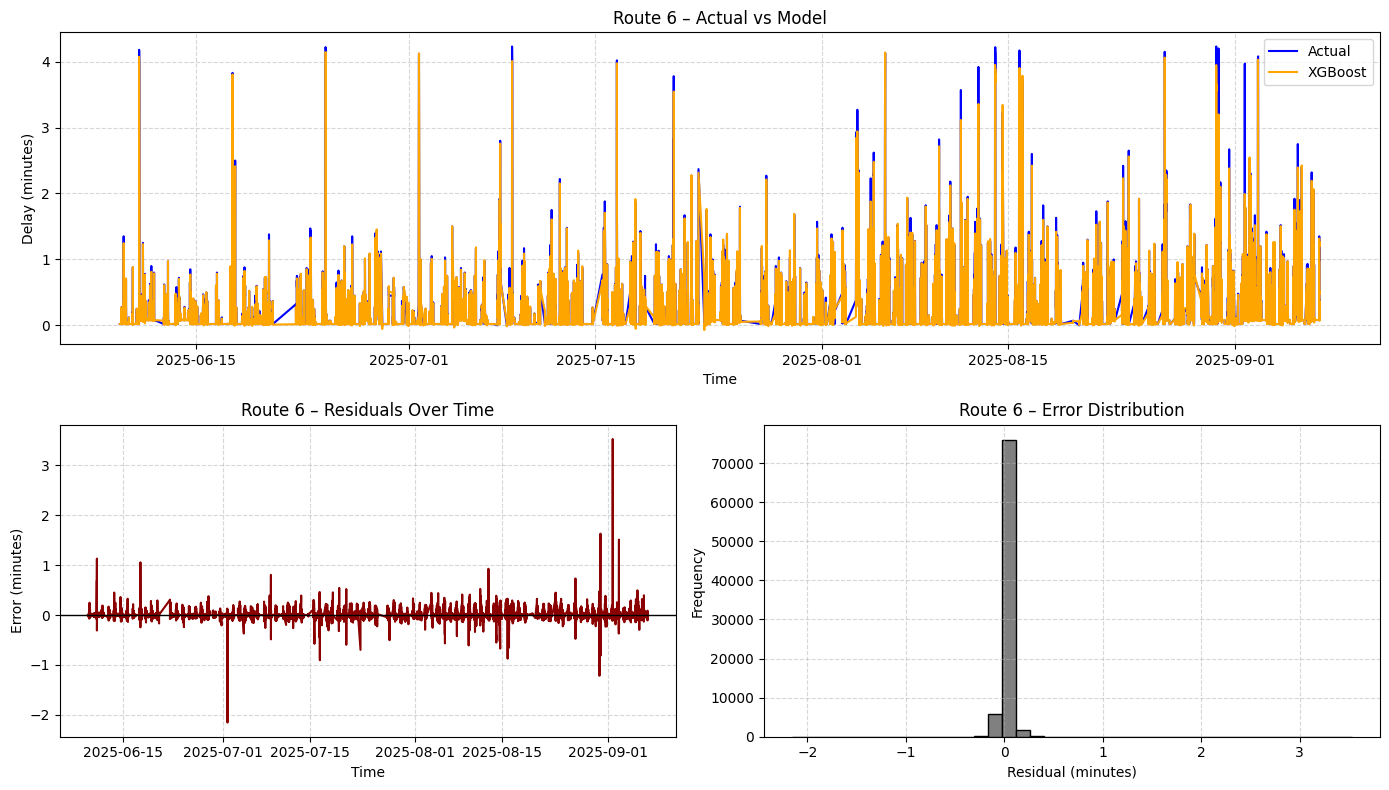


Route: Route 6
Best Model: XGBoost
Holdout MAE: 0.0165
Holdout RMSE: 0.0487
Baseline MAE: 0.0213
Improvement vs Baseline: 22.23%


In [166]:
def plot_route_diagnostics(route):
    '''
    Function to plot:
    - predicted vs actual delay over time
    - residuals over time
    - residual distribution

    for a given route.
    '''
    y_true = y_test_holdout[route].values
    y_pred = final_predictions[route]
    time_axis = df.loc[y_test_holdout[route].index, 'timestamp']

    # Get metrics for subtitle
    row = best_models_df[best_models_df['Route'] == route].iloc[0]
    best_model_name = row['Model']

    # Plot layout
    fig = plt.figure(figsize=(14,8))

    # Top: Predicted vs Baseline vs Actual
    ax1 = plt.subplot2grid((2,2),(0,0),colspan=2)
    ax1.plot(time_axis, y_true, label='Actual', color='blue')
    ax1.plot(time_axis, y_pred, label=f'{best_model_name}', color='orange')
    ax1.set_title(f'{route} – Actual vs Model')
    ax1.set_xlabel('Time'); ax1.set_ylabel('Delay (minutes)')
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.legend()

    # Bottom-left: Residuals over time
    residuals = y_true - y_pred
    ax2 = plt.subplot2grid((2,2),(1,0))
    ax2.plot(time_axis, residuals, color='darkred')
    ax2.axhline(0, color='black', linewidth=1)
    ax2.set_title(f'{route} – Residuals Over Time')
    ax2.set_xlabel('Time'); ax2.set_ylabel('Error (minutes)')
    ax2.grid(True, linestyle='--', alpha=0.5)

    # Bottom-right: Error histogram
    ax3 = plt.subplot2grid((2,2),(1,1))
    ax3.hist(residuals, bins=40, color='gray', edgecolor='black')
    ax3.set_title(f'{route} – Error Distribution')
    ax3.set_xlabel('Residual (minutes)'); ax3.set_ylabel('Frequency')
    ax3.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Print metrics 
    print(f'\nRoute: {route}')
    print(f'Best Model: {best_model_name}')
    print(f'Holdout MAE: {row["Holdout MAE"]}')
    print(f'Holdout RMSE: {row["Holdout RMSE"]}')
    print(f'Baseline MAE: {row["Baseline MAE"]}')
    print(f'Improvement vs Baseline: {row["Improvement Over Baseline (%)"]}%')

for route in ['Route 4', 'Route 11', 'Route 6']:
    plot_route_diagnostics(route)

### Plot Insights

#### Route 4 - High-Improvement Case
Predicted values closely mirror the actual delay curve, and residuals are small and randomly distributed around zero. The residual distribution is symmetric with a tight spread, suggesting the model generalizes well and captures the underlying temporal patterns effectively.

#### Route 11 - Typical Case
The model follows general delay trends but exhibits mild bias during short-term fluctuations. Residual plots show occasional clusters of positive or negative errors, suggesting moments of underestimation during high-delay periods. The residual distribution remains approximately normal, with moderate variance.

#### Route 6 - Low-Improvement Case
Predictions show limited responsiveness to real-world variations, resulting in flatter predicted curves relative to actual delays. Residuals display visible structure and potential autocorrelation, indicating the model struggles to adapt to abrupt changes. The residual distribution is wider and skewed, pointing toward systematic bias and potential feature gaps.

---

### Summary

Overall, the diagnostics confirm that while the models achieve meaningful improvement over baseline for most routes, performance heterogeneity persists. High-performing routes (e.g., Route 4) benefit from strong temporal signal capture, whereas low-performing ones (e.g., Route 6) may require additional features, finer time resolution, or route-specific tuning to better represent their distinct delay behavior.

# Block 4: Model Optimization & Hyperparameter Tuning

This block improves each route’s best model by optimizing its hyperparameters while keeping the
time-series structure intact.  
We apply `RandomizedSearchCV` with `TimeSeriesSplit(n_splits=3)` and
`neg_mean_absolute_error` as the scorer.

Search spaces focus on the most influential parameters for tree-based models
(depth, learning rate, and subsampling for XGBoost; tree count, depth, and split rules for Random Forest).


All other data-splitting and feature-engineering choices remain fixed, so any improvement
is attributable solely to hyperparameter optimization.


In [167]:
warnings.filterwarnings("ignore", message="A worker stopped while")

# Parameter grids
xgb_param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}
rf_param_grid = {
    "n_estimators": [200, 300, 500],
    "max_depth": [6, 10, None],
    "max_features": ["sqrt", "log2", None],
    "min_samples_split": [2, 5, 10],
}

# Automatically build best model mapping from best_models_df
best_models_map = dict(zip(best_models_df["Route"], best_models_df["Model"]))


# Storage 
tuned_models, tuned_predictions, tuned_rows = {}, {}, []

for route in tqdm(best_models_map.keys(), desc="Hyperparameter tuning by route"):
    model_type = best_models_map[route]
    X_cv, y_cv = X_train_cv[route], y_train_cv[route]
    folds = tscv_splits[route]
    X_test, y_test = X_test_holdout[route], y_test_holdout[route]

    if model_type == "XGBoost":
        base = XGBRegressor(
            random_state=42, tree_method="hist",
            n_estimators=300, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.9
        )
        param_grid = xgb_param_grid
    else:
        base = RandomForestRegressor(
            random_state=42, n_estimators=300, max_depth=8
        )
        param_grid = rf_param_grid

    tuner = RandomizedSearchCV(
        estimator=base,
        param_distributions=param_grid,
        n_iter=10,
        scoring="neg_mean_absolute_error",
        cv=folds,
        n_jobs=-1,
        verbose=0,
        refit=True,
        random_state=42,
    )

    tuner.fit(X_cv, y_cv)
    best_est = tuner.best_estimator_

    # CV MAE
    cv_mae = np.mean([
        mean_absolute_error(y_cv.iloc[val], best_est.predict(X_cv.iloc[val]))
        for _, val in folds
    ])

    # Holdout evaluation
    y_pred = best_est.predict(X_test)
    hold_mae = mean_absolute_error(y_test, y_pred)
    hold_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    tuned_models[route] = best_est
    tuned_predictions[route] = y_pred

    tuned_rows.append({
        "Route": route,
        "Model": model_type,
        "Best Params": tuner.best_params_,
        "Tuned CV MAE": cv_mae,
        "Tuned Holdout MAE": hold_mae,
        "Tuned Holdout RMSE": hold_rmse,
    })

# Summary table 
tuned_df = (pd.DataFrame(tuned_rows)
    .assign(RouteNum=lambda d: d["Route"].str.extract(r"(\d+)").astype(int))
    .sort_values("RouteNum")
    .drop(columns="RouteNum"))

tuned_df = tuned_df.round({
    "Tuned CV MAE": 4, "Tuned Holdout MAE": 4, "Tuned Holdout RMSE": 4
})

tuned_df


Hyperparameter tuning by route: 100%|██████████| 12/12 [23:22<00:00, 116.89s/it]


,Route,Model,Best Params,Tuned CV MAE,Tuned Holdout MAE,Tuned Holdout RMSE
0,Route 1,XGBoost,"{'subsample': 1.0, 'n_estimators': 200, 'max_d...",0.0109,0.0151,0.0297
1,Route 2,RandomForest,"{'n_estimators': 300, 'min_samples_split': 10,...",0.0043,0.0205,0.0857
2,Route 3,XGBoost,"{'subsample': 1.0, 'n_estimators': 200, 'max_d...",0.0073,0.0087,0.0177
3,Route 4,XGBoost,"{'subsample': 1.0, 'n_estimators': 200, 'max_d...",0.0053,0.0089,0.0191
4,Route 5,XGBoost,"{'subsample': 1.0, 'n_estimators': 400, 'max_d...",0.0016,0.0105,0.0810
5,Route 6,XGBoost,"{'subsample': 0.8, 'n_estimators': 200, 'max_d...",0.0061,0.0123,0.0405
6,Route 7,RandomForest,"{'n_estimators': 300, 'min_samples_split': 10,...",0.0012,0.0077,0.0269
7,Route 8,RandomForest,"{'n_estimators': 300, 'min_samples_split': 10,...",0.0015,0.0123,0.0628
8,Route 10,RandomForest,"{'n_estimators': 300, 'min_samples_split': 10,...",0.0049,0.0190,0.0848
9,Route 11,RandomForest,"{'n_estimators': 300, 'min_samples_split': 10,...",0.0027,0.0163,0.0663


## Hyperparameter Tuning Results and Model Comparison

### Comparison Method
The table `tuned_comparison_df` merges results from the original and tuned models, allowing direct comparison of **Holdout MAE** and **RMSE** for each route.  

Performance change is calculated as:

$$
\Delta MAE = MAE_{tuned} - MAE_{original}
$$

A negative ΔMAE indicates improvement, while positive values suggest degradation or no change.


In [172]:
# Merge original and tuned results
tuned_comparison_df = (
    best_models_df.merge(
        tuned_df,
        on='Route',
        suffixes=(' Original', ' Tuned')
    )
)

# Compute performance changes (negative = improvement)
tuned_comparison_df['MAE Change'] = (
    tuned_comparison_df['Tuned Holdout MAE'] - tuned_comparison_df['Holdout MAE']
)
tuned_comparison_df['RMSE Change'] = (
    tuned_comparison_df['Tuned Holdout RMSE'] - tuned_comparison_df['Holdout RMSE']
)

# Percentage Improvement
tuned_comparison_df['Improvement (%)'] = (
    (tuned_comparison_df['Holdout MAE'] - tuned_comparison_df['Tuned Holdout MAE'])
    / tuned_comparison_df['Holdout MAE'] * 100
)

# Label performance outcome
tuned_comparison_df['Performance'] = np.where(
    tuned_comparison_df['Improvement (%)'] > 0, 'Improved', 'Worse or Same'
)

# Round numeric columns for clarity
tuned_comparison_df = tuned_comparison_df.round({
    'Holdout MAE': 4,
    'Tuned Holdout MAE': 4,
    'MAE Change': 4,
    'Holdout RMSE': 4,
    'Tuned Holdout RMSE': 4,
    'RMSE Change': 4, 
    'Improvement (%)': 2
})

tuned_comparison_df[['Route', 'Model Tuned', 'Holdout MAE', 'Tuned Holdout MAE', 'MAE Change', 'Improvement (%)', 'Performance']]


,Route,Model Tuned,Holdout MAE,Tuned Holdout MAE,MAE Change,Improvement (%),Performance
0,Route 1,XGBoost,0.0202,0.0151,-0.0051,25.25,Improved
1,Route 2,RandomForest,0.0250,0.0205,-0.0045,18.00,Improved
2,Route 3,XGBoost,0.0109,0.0087,-0.0022,20.18,Improved
3,Route 4,XGBoost,0.0114,0.0089,-0.0025,21.93,Improved
4,Route 5,XGBoost,0.0074,0.0105,0.0031,-41.89,Worse or Same
5,Route 6,XGBoost,0.0165,0.0123,-0.0042,25.45,Improved
6,Route 7,RandomForest,0.0113,0.0077,-0.0036,31.86,Improved
7,Route 8,RandomForest,0.0180,0.0123,-0.0057,31.67,Improved
8,Route 10,RandomForest,0.0297,0.0190,-0.0107,36.03,Improved
9,Route 11,RandomForest,0.0212,0.0163,-0.0049,23.11,Improved


## Interpretation

After tuning, 11 of 12 routes achieved lower holdout MAE and RMSE, confirming that parameter optimization improved model generalization. Route 5 significantly worsened after tuning, suggesting overfitting due to limited variation or sensitivity to rare outlier delays.

We will take a closer look at Route 5 to understand why performance did not improve with hyperparameter tuning.


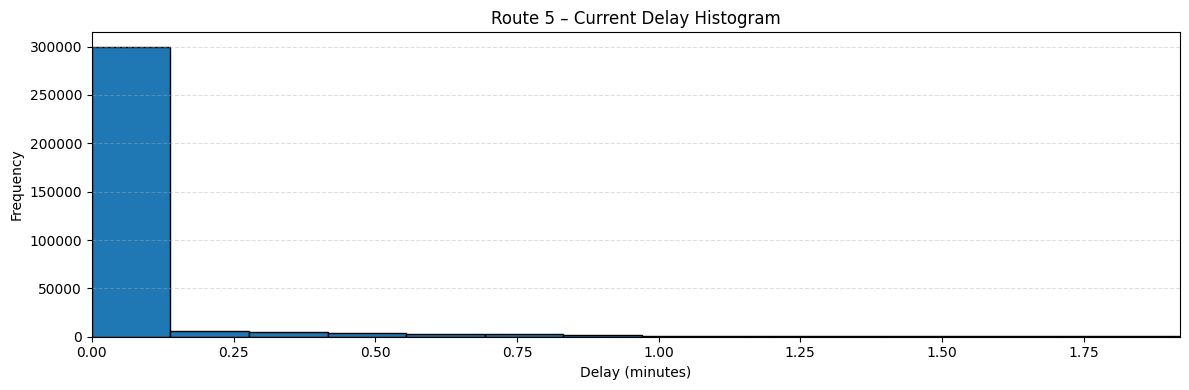

In [169]:
route = 'Route 5'
s = df.loc[df['route'] == route, 'current_delay'].dropna().astype(float)

# Histogram with focus on operational range - extend to 99th percentile for readability
xmax = float(s.quantile(0.99)) * 1.2 if s.size else 1.0
plt.figure(figsize=(12,4))
plt.hist(s, bins=50, edgecolor='black')
plt.title(f'{route} – Current Delay Histogram')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')
plt.xlim(0, xmax)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Delay Variance Analysis – Route 5

To verify whether Route 5 required additional feature or model complexity, delay variance was examined.  
The histogram below shows that almost all `current_delay` values cluster at or near **0 minutes**, with a sharp drop-off after 0.25 minutes.   

This concentration indicates that Route 5 operates with **minimal variability**, where traffic on this route is almost never delayed beyond a few seconds. Because the target variable has such low dispersion, adding model complexity cannot improve predictive accuracy meaningfully: the model’s optimal strategy is to predict a near-zero delay.  
These findings justify why Route 5 shows negligible gains from hyperparameter tuning and why it should be treated as a **low-variance, operationally stable route**.

---

## Summary
 
Overall, the improvements demonstrate that careful hyperparameter tuning enhances model stability and predictive precision without compromising interpretability. Random Forests benefited most from adjustments to tree depth and sample splits, while XGBoost models improved with moderate regularization and higher learning rate flexibility.

In [170]:
# Create a directory for all outputs
os.makedirs('routes_saved_models', exist_ok=True)

# --- 1. Save datasets and splits ---
joblib.dump(df, 'routes_saved_models/full_dataset.pkl')
joblib.dump(X_train_cv, 'routes_saved_models/X_train_cv.pkl')
joblib.dump(y_train_cv, 'routes_saved_models/y_train_cv.pkl')
joblib.dump(X_test_holdout, 'routes_saved_models/X_test_holdout.pkl')
joblib.dump(y_test_holdout, 'routes_saved_models/y_test_holdout.pkl')
joblib.dump(tscv_splits, 'routes_saved_models/tscv_splits.pkl')

# --- 2. Save model results and performance tables ---
joblib.dump(comparison_df, 'routes_saved_models/comparison_df.pkl')
joblib.dump(best_models_df, 'routes_saved_models/best_models_df.pkl')

# --- 3. Save trained models (original + tuned) ---
joblib.dump(final_predictions, 'routes_saved_models/final_predictions.pkl')
joblib.dump(baseline_predictions, 'routes_saved_models/baseline_predictions.pkl')
joblib.dump(final_residuals, 'routes_saved_models/final_residuals.pkl')

print('All key datasets, models, and results have been saved in /routes_saved_models')


All key datasets, models, and results have been saved in /routes_saved_models
